In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import astropy.io.fits as fits

import pysm3
import pysm3.units as u



import sys
sys.path.append('/home/rguidetti')
from PolAngle import *
from beam import * 
from map import *
from convolution import * 
from beam_class import *
from PatchFunctions import *  # nuove funzioni in quanto quelle vecchie lavoravano con mappe NxN. Queste funzionano per mappe rettangolari Nx,Ny

import lmfit 

# POWER SPECTRA

In [3]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0.001)
pars.set_for_lmax(2500, lens_potential_accuracy=0)
pars.WantTensors= True

In [4]:
#calculate results for these parameters
results = camb.get_results(pars)

In [5]:
#get dictionary of CAMB power spectra
powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
for name in powers: print(name)

total
unlensed_scalar
unlensed_total
lensed_scalar
tensor
lens_potential


(2551, 4)


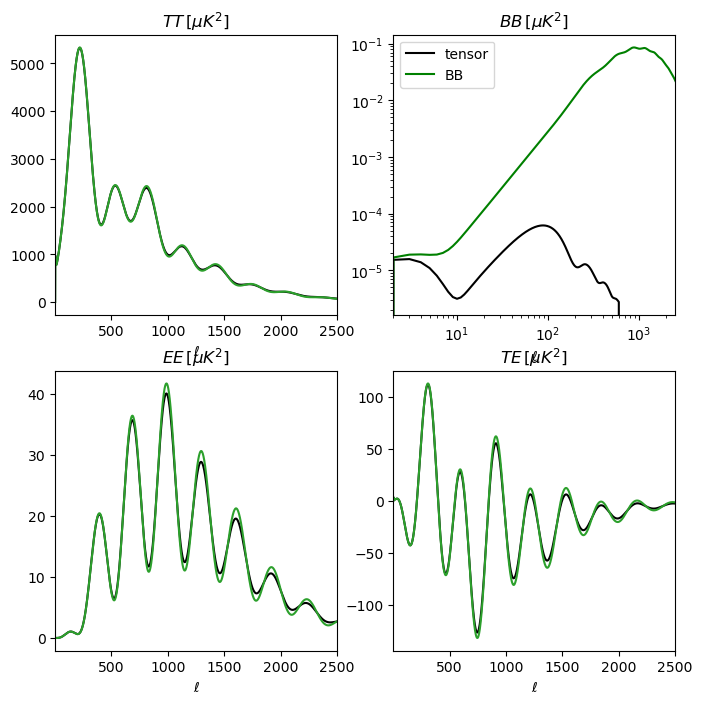

In [6]:
#plot the total lensed CMB power spectra versus unlensed, and fractional difference
totCL = powers['total']
unlensedCL = powers['unlensed_scalar']
tensor = powers['tensor']
print(totCL.shape)

ls = np.arange(totCL.shape[0])
fig, ax = plt.subplots(2,2, figsize = (8,8))

# TT
ax[0,0].plot(ls,totCL[:,0], color='k')
ax[0,0].plot(ls,unlensedCL[:,0], color='C2')
ax[0,0].set_title(r'$TT\, [\mu K^2]$')

#EE
ax[1,0].plot(ls,totCL[:,1], color='k')
ax[1,0].plot(ls,unlensedCL[:,1], color='C2')
ax[1,0].set_title(r'$EE\, [\mu K^2]$')

#BB
ax[0,1].loglog(ls,tensor[:,2], color='k', label="tensor")
ax[0,1].loglog(ls,totCL[:,2], color='g', label="BB")
ax[0,1].set_title(r'$BB\, [\mu K^2]$')
ax[0,1].legend()

# TE
ax[1,1].plot(ls,totCL[:,3], color='k')
ax[1,1].plot(ls,unlensedCL[:,3], color='C2')
ax[1,1].set_title(r'$TE\, [\mu K^2]$')

for ax in ax.reshape(-1): 
    ax.set_xlim([2,2500])
    ax.set_xlabel(r'$\ell$')

(2551, 4)


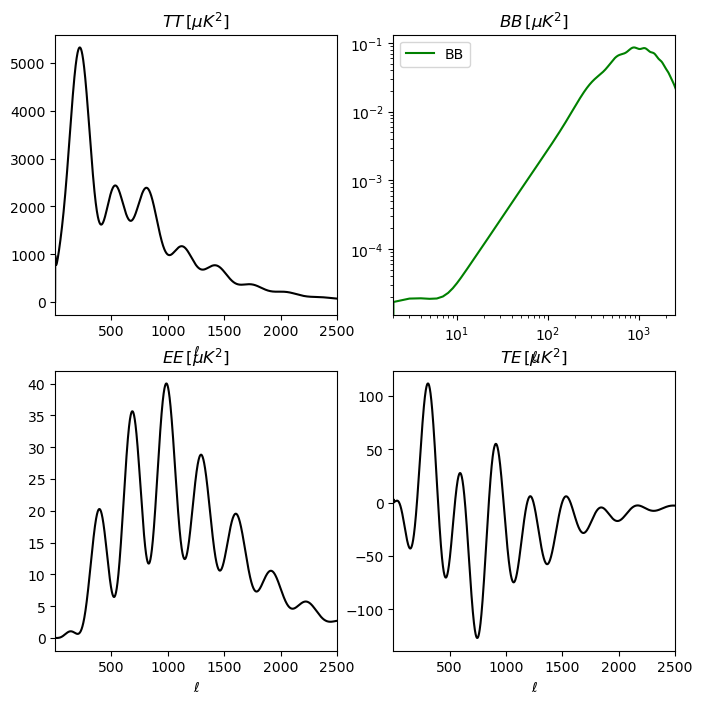

In [7]:
#plot the total lensed CMB power spectra versus unlensed, and fractional difference
totCL = powers['total']
unlensedCL = powers['unlensed_scalar']
tensor = powers['tensor']
print(totCL.shape)

ls = np.arange(totCL.shape[0])
fig, ax = plt.subplots(2,2, figsize = (8,8))

# TT
ax[0,0].plot(ls,totCL[:,0], color='k')
ax[0,0].set_title(r'$TT\, [\mu K^2]$')

#EE
ax[1,0].plot(ls,totCL[:,1], color='k')
ax[1,0].set_title(r'$EE\, [\mu K^2]$')

#BB
#ax[0,1].loglog(ls,tensor[:,2], color='k', label="tensor")
ax[0,1].loglog(ls,totCL[:,2], color='g', label="BB")
ax[0,1].set_title(r'$BB\, [\mu K^2]$')
ax[0,1].legend()

# TE
ax[1,1].plot(ls,totCL[:,3], color='k')
ax[1,1].set_title(r'$TE\, [\mu K^2]$')

for ax in ax.reshape(-1): 
    ax.set_xlim([2,2500])
    ax.set_xlabel(r'$\ell$')

In [8]:
# rinomino per comodità
TT_ps  = totCL[:,0] 
TE_ps  = totCL[:,3] 
EE_ps  = totCL[:,1] 
BB_ps  = totCL[:,2]
BB_ps_tensor  = tensor[:,2]

### PS Saving

In [9]:
np.savetxt('Original_PS_001.txt', np.vstack((TT_ps, TE_ps, EE_ps, BB_ps, BB_ps_tensor)), fmt='%8f')

### Maps

Map with 1024 x 1024 pixels, each of 0.5 arcmin, for a total dimension of 8.53 x 8.53 gradi


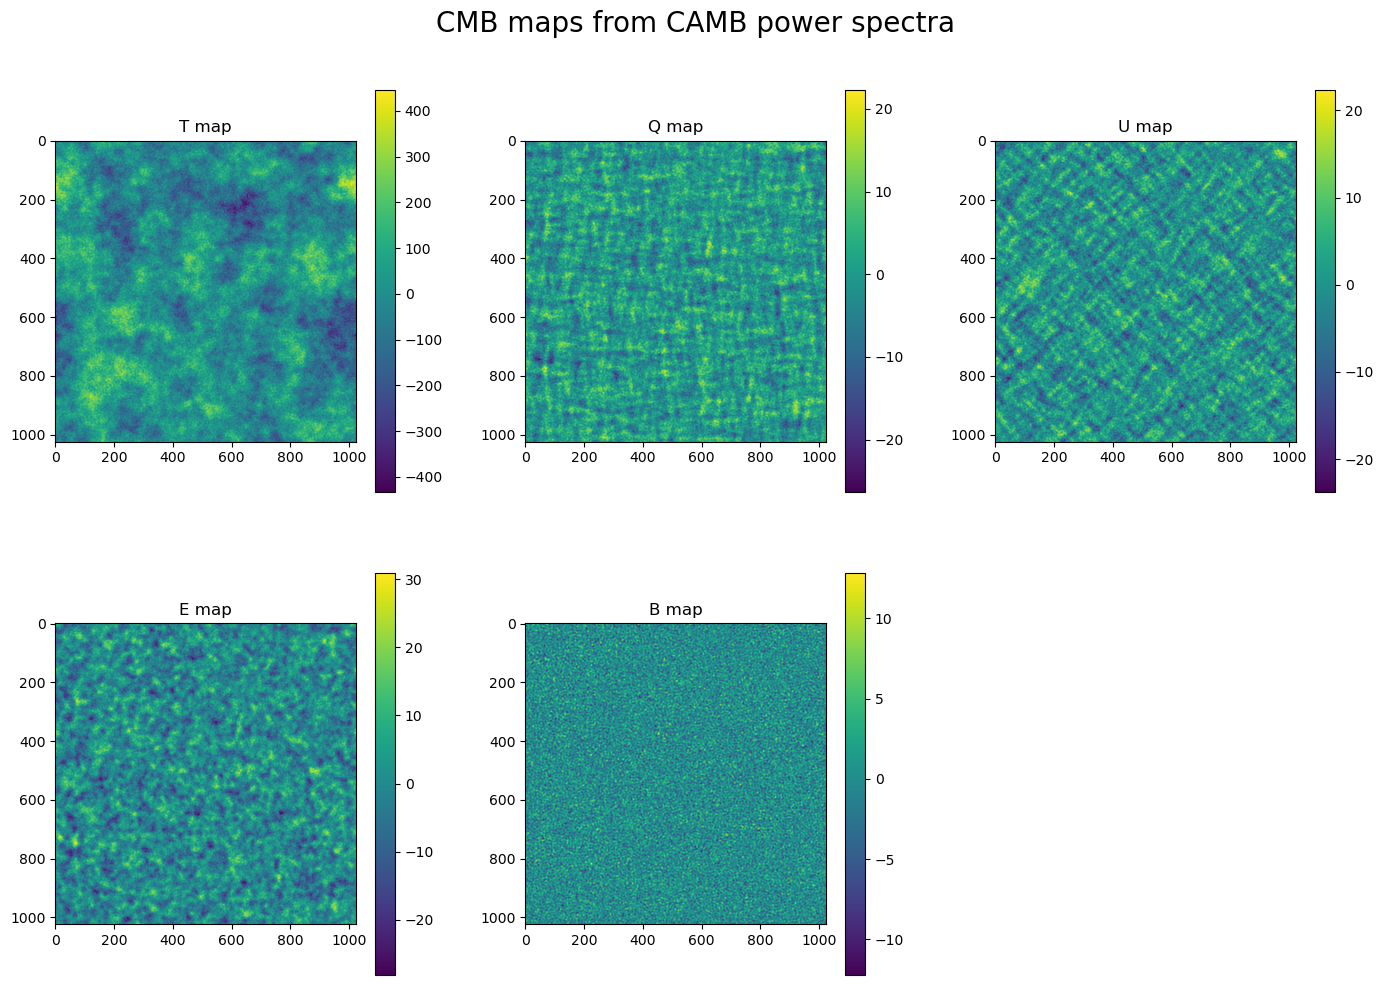

In [10]:
# MAP PARAMETERS

pix_size         = 0.5                              #arcmin
N                = 2**10                            #num pixel lineare
X_width, Y_width = N*pix_size/60., N*pix_size/60.   #dimensioni mappa in gradi
Nsqdeg           = X_width**2

c_min, c_max     = -200, 200                        #color map


# If I want to start from a given map dimension instead of number and size of pixels I do:
#N = (X_width * 60)/ pix_size #pixel number

print(f"Map with {N} x {N} pixels, each of {pix_size} arcmin, for a total dimension of {X_width:.2f} x {Y_width:.2f} gradi")


nbig = 5000


#################################################################################################################################################################################################
# ORIGINAL MAPS

ell_big = np.arange(nbig)

TT_ps_big = np.zeros(nbig)
TT_ps_big[ls.astype(int)] = TT_ps

EE_ps_big = np.zeros(nbig)
EE_ps_big[ls.astype(int)] = EE_ps

BB_ps_big = np.zeros(nbig)
BB_ps_big[ls.astype(int)] = BB_ps_tensor

TE_ps_big = np.zeros(nbig)
TE_ps_big[ls.astype(int)] = TE_ps

ell    = ell_big
ps_TT  = TT_ps_big + 1e-3   
ps_EE  = EE_ps_big + 1e-3
ps_BB  = BB_ps_big + 1e-3
ps_TE  = TE_ps_big

Temp_point_source_spectrum = ps_TT[1000]*(ell/3000.)**2.
Pol_point_source_spectrum  = ps_EE[1500]*(ell/4500.)**2.

ps_TT = ps_TT + Temp_point_source_spectrum  
ps_EE = ps_EE + Pol_point_source_spectrum
ps_BB = ps_BB + Pol_point_source_spectrum



T_map, Q_map, U_map, E_map, B_map = make_CMB_maps(N,pix_size,ell,ps_TT,ps_EE,ps_TE,ps_BB)

#################################################################################################################################################################################################


Map_to_Plot = [T_map, Q_map, U_map, E_map, B_map]
title = ["T map","Q map", "U map", "E map","B map"]
c_factor_max = [np.max(Map_to_Plot[0]), np.max(Map_to_Plot[1]), np.max(Map_to_Plot[2]), np.max(Map_to_Plot[3]), np.max(Map_to_Plot[4])]
c_factor_min = [np.min(Map_to_Plot[0]), np.min(Map_to_Plot[1]), np.min(Map_to_Plot[2]), np.min(Map_to_Plot[3]), np.min(Map_to_Plot[4])]


fig, axs = plt.subplots(2, 3, figsize=(14, 10))
axs      = axs.flatten()
for i, (map_data, c_factor_iter_min, c_factor_iter_max) in enumerate(zip(Map_to_Plot, c_factor_min, c_factor_max)):
    im = axs[i].imshow(map_data, vmin=c_factor_iter_min, vmax=c_factor_iter_max)
    axs[i].set_title(title[i])
    plt.colorbar(im, ax=axs[i], orientation='vertical')
        
    
fig.delaxes(axs[-1])
plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)
plt.suptitle(f'CMB maps from CAMB power spectra', fontsize=20)
plt.show()

# Unperturbed PS


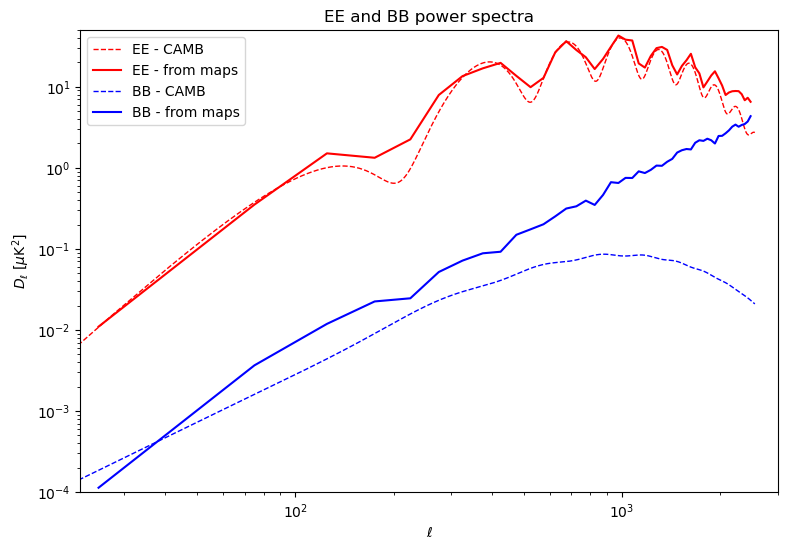

In [11]:
delta_l = 50.
l_max   = 2500

# Power spectra from maps
binned_l_E_maps, binned_spectrum_E_maps = calculate_2d_spectrum(E_map,E_map,delta_l,l_max,pix_size,N)
binned_l_B_maps, binned_spectrum_B_maps = calculate_2d_spectrum(B_map,B_map,delta_l,l_max,pix_size,N)


######################################################################################################################################################################

plt.figure(figsize=(9, 6))

# EE
plt.loglog(ls, EE_ps, label="EE - CAMB", c="r", linewidth=1, linestyle="--")
plt.loglog(binned_l_E_maps, binned_spectrum_E_maps* binned_l_E_maps * (binned_l_E_maps+1.)/2. / np.pi,color='r',label="EE - from maps")

#BB
plt.loglog(ls, BB_ps, label="BB - CAMB", c="b", linewidth=1, linestyle="--")
plt.loglog(binned_l_B_maps, binned_spectrum_B_maps* binned_l_B_maps * (binned_l_B_maps+1.)/2. / np.pi,color='b', label="BB - from maps")

plt.xlim(22,3000)
plt.ylim(1e-4, 50)
plt.title("EE and BB power spectra")
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.legend()
plt.show()

### Use the PolAngle_PS and PolAngle_Map notebooks to generate the pertubed PS/maps, then come back here to compare the results

# Polarization angle - approaches' comparison

In [12]:
# LEGGO DATI DA PERTURBAZIONE DEI PS


# Mappe perturbate
Maps_PSpert = np.loadtxt('Maps_PSpert_001.txt')

#PS perturbati
PS_PSpert   = np.loadtxt('EB_PS_PSpert_001.txt')


# Assegno nuove matrici
matrix_rows = Maps_PSpert.shape[0] // 4  # 4 matrices stacked vertically
Maps_PSpert = Maps_PSpert.reshape(4, matrix_rows, -1)

Emap_PSpert, Bmap_PSpert, Qmap_PSpert, Umap_PSpert = Maps_PSpert

# Assegno nuovi PS
EPS_PSpert  = PS_PSpert[0]
BPS_PSpert  = PS_PSpert[1]

In [13]:
# LEGGO DATI DA PERTURBAZIONE DELLE MAPPE

# Mappe perturbate
Maps_MAPSpert = np.loadtxt('Maps_MAPSpert_001.txt')


#PS perturbati
PS_MAPSpert   = np.loadtxt('EB_PS_MAPSpert_001.txt')


# Assegno nuove matrici
#matrix_rows   = Maps_MAPSpert.shape[0] // 4  # 4 matrices stacked vertically
Maps_MAPSpert = Maps_MAPSpert.reshape(4, matrix_rows, -1)

Emap_MAPSpert, Bmap_MAPSpert, Qmap_MAPSpert, Umap_MAPSpert = Maps_MAPSpert

# Assegno nuovi PS
EPS_MAPSpert  = PS_MAPSpert[0]
BPS_MAPSpert  = PS_MAPSpert[1]

In [14]:
np.shape(EPS_PSpert)

(50,)

In [15]:
# parametri mappa

pix_size = 0.5    #arcmin
N        = 2**10  #num pixel lineare
X_width, Y_width = N*pix_size/60., N*pix_size/60.   #dimensioni mappa in gradi

c_min, c_max     = -200, 200                        #color map

#se voglio invece partire da una dimensione fissata di mappa e pixel, uso questa formula per trovare quanti pixel mi servono
#N = (X_width * 60)/ pix_size #pixel number

print(f"Mappa con {N} x {N} pixels, ognuno di {pix_size} arcmin, per una dimensione totale di {X_width:.2f} x {Y_width:.2f} gradi")


nbig = 5000

Mappa con 1024 x 1024 pixels, ognuno di 0.5 arcmin, per una dimensione totale di 8.53 x 8.53 gradi


### map's comparison

In [16]:
map_list = [Emap_PSpert, Bmap_PSpert, Qmap_PSpert, Umap_PSpert, Emap_MAPSpert, Bmap_MAPSpert, Qmap_MAPSpert, Umap_MAPSpert]
title_list = ["E_PSpert", "B_PSpert", "Q_PSpert", "U_PSpert", "E_MAPSpert", "B_MAPSpert", "Q_MAPSpert", "U_MAPSpert"]

In [17]:
'''
def Plot_CMB_Map_compact(ax, Map_to_Plot, c_min, c_max, X_width, Y_width):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    im = ax.imshow(Map_to_Plot, interpolation='bilinear', origin='lower', cmap='RdBu_r')
    im.set_clim(c_min, c_max)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    im.set_extent([0, X_width, 0, Y_width])
    ax.set_ylabel('angle $[^\circ]$')
    ax.set_xlabel('angle $[^\circ]$')
    cbar.set_label('temperature [uK]', rotation=270)
'''

'\ndef Plot_CMB_Map_compact(ax, Map_to_Plot, c_min, c_max, X_width, Y_width):\n    from mpl_toolkits.axes_grid1 import make_axes_locatable\n    im = ax.imshow(Map_to_Plot, interpolation=\'bilinear\', origin=\'lower\', cmap=\'RdBu_r\')\n    im.set_clim(c_min, c_max)\n    divider = make_axes_locatable(ax)\n    cax = divider.append_axes("right", size="5%", pad=0.05)\n    cbar = plt.colorbar(im, cax=cax)\n    im.set_extent([0, X_width, 0, Y_width])\n    ax.set_ylabel(\'angle $[^\\circ]$\')\n    ax.set_xlabel(\'angle $[^\\circ]$\')\n    cbar.set_label(\'temperature [uK]\', rotation=270)\n'

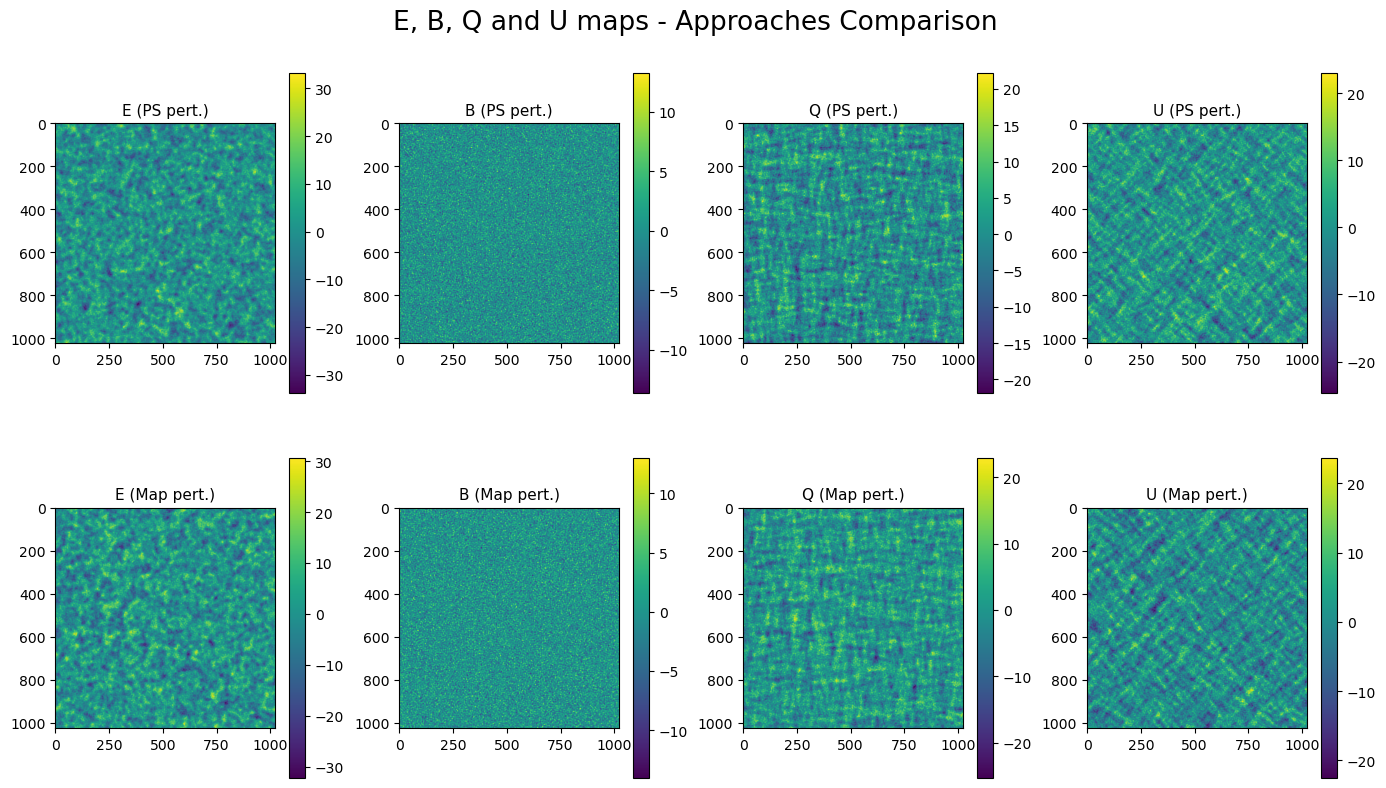

"\n\nfig, axs = plt.subplots(2, 4, figsize=(18, 10))\naxs      = axs.flatten()\n\n\nfor i, map_data in enumerate(map_list):\n\n        Plot_CMB_Map_compact(axs[i], map_data, c_min/30, c_max/30, X_width, Y_width)\n        axs[i].set_title(title_list[i])\n        \n        \nplt.tight_layout()\nplt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)\nplt.suptitle('Confronto mappe perturbate - PS vs MAPS - r = 0.001', fontsize=20)\n#plt.savefig('C:/Users/guide/Documents/University/TESI/immagini/Maps_PSvsMAPS_001.png')  \nplt.show()\n"

In [18]:
Map_to_Plot = [Emap_PSpert, Bmap_PSpert, Qmap_PSpert, Umap_PSpert,
               Emap_MAPSpert, Bmap_MAPSpert, Qmap_MAPSpert, Umap_MAPSpert]
title = ["E (PS pert.)", "B (PS pert.)", "Q (PS pert.)", "U (PS pert.)", 
         "E (Map pert.)", "B (Map pert.)", "Q (Map pert.)", "U (Map pert.)"]
c_factor_max = [np.max(Map_to_Plot[0]), np.max(Map_to_Plot[1]), np.max(Map_to_Plot[2]), np.max(Map_to_Plot[3]), np.max(Map_to_Plot[4]), np.max(Map_to_Plot[5]), np.max(Map_to_Plot[6]), np.max(Map_to_Plot[7])]
c_factor_min = [np.min(Map_to_Plot[0]), np.min(Map_to_Plot[1]), np.min(Map_to_Plot[2]), np.min(Map_to_Plot[3]), np.min(Map_to_Plot[4]), np.min(Map_to_Plot[5]), np.min(Map_to_Plot[6]), np.min(Map_to_Plot[7])]


fig, axs = plt.subplots(2, 4, figsize=(14, 8))
axs      = axs.flatten()
for i, (map_data, c_factor_iter_min, c_factor_iter_max) in enumerate(zip(Map_to_Plot, c_factor_min, c_factor_max)):
    im = axs[i].imshow(map_data, vmin=c_factor_iter_min, vmax=c_factor_iter_max)
    axs[i].set_title(title[i], fontsize = 11)
    plt.colorbar(im, ax=axs[i], orientation='vertical')
    
#fig.delaxes(axs[-1])
plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)
plt.suptitle(f'E, B, Q and U maps - Approaches Comparison', fontsize=19)
plt.show()


'''

fig, axs = plt.subplots(2, 4, figsize=(18, 10))
axs      = axs.flatten()


for i, map_data in enumerate(map_list):

        Plot_CMB_Map_compact(axs[i], map_data, c_min/30, c_max/30, X_width, Y_width)
        axs[i].set_title(title_list[i])
        
        
plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)
plt.suptitle('Confronto mappe perturbate - PS vs MAPS - r = 0.001', fontsize=20)
#plt.savefig('C:/Users/guide/Documents/University/TESI/immagini/Maps_PSvsMAPS_001.png')  
plt.show()
'''

### PS comparison

In [19]:
binned_l = np.loadtxt('binned_l.txt')

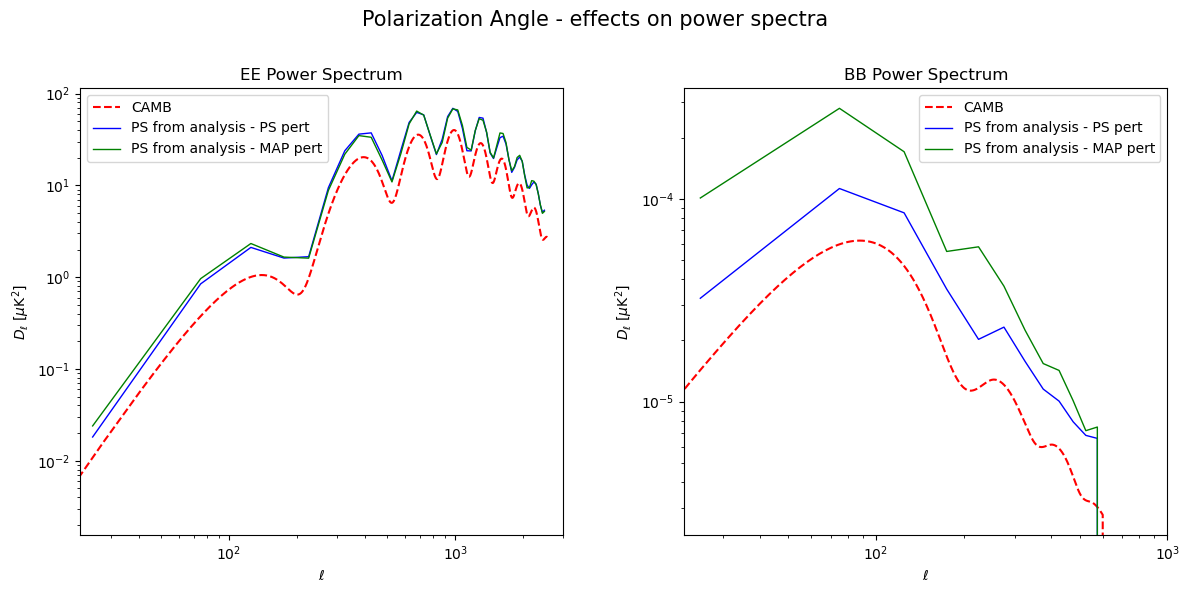

In [20]:
#binned_l = [25,75,125,175,225,275,325,375,425,475,525,575,625,675,725,775,825,875,925,975,1025,1075,1125,1175,1225,1275,1325,1375
#,1425, 1475, 1525, 1575, 1625, 1675, 1725, 1775, 1825, 1875, 1925, 1975, 2025, 2075, 2125, 2175, 2225, 2275, 2325, 2375, 2425, 2475]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))  

ax[0].loglog(ls,EE_ps, color='r', label="CAMB", linestyle="--")
ax[0].loglog(binned_l,EPS_PSpert,color='blue', label="PS from analysis - PS pert", linewidth=1)
ax[0].loglog(binned_l,EPS_MAPSpert,color='green', label="PS from analysis - MAP pert", linewidth=1)

ax[0].set_title("EE Power Spectrum")
ax[0].set_ylabel('$D_{\ell}$ [$\mu$K$^2$]')
ax[0].set_xlabel('$\ell$')
ax[0].set_xlim(22,3000)
ax[0].legend()

#
ax[1].loglog(ls,BB_ps_tensor, color='r', label="CAMB", linestyle="--")
ax[1].loglog(binned_l,BPS_PSpert,color='blue', label="PS from analysis - PS pert", linewidth=1)
ax[1].loglog(binned_l,BPS_MAPSpert,color='green', label="PS from analysis - MAP pert", linewidth=1)

ax[1].set_title("BB Power Spectrum")
ax[1].set_ylabel('$D_{\ell}$ [$\mu$K$^2$]')
ax[1].set_xlabel('$\ell$')
ax[1].set_xlim(22,1000)
ax[1].legend()

#

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.85)
plt.suptitle('Polarization Angle - effects on power spectra', fontsize=15)
#plt.savefig('C:/Users/guide/Documents/University/TESI/immagini/PS_PSvsMAPS_001.png')  
plt.show()